In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import joblib
from tqdm import tqdm

%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from scipy import stats

import xgboost as xgb

import torch

## Load Dataset

In [3]:
df = pd.read_csv("./data/medicalpremium.csv")
df["PremiumPrice"] = df["PremiumPrice"] * 0.056
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,1400.0
1,60,1,0,0,0,180,73,0,0,0,1624.0
2,36,1,1,0,0,158,59,0,0,1,1288.0
3,52,1,1,0,1,183,93,0,0,2,1568.0
4,38,0,0,0,1,166,88,0,0,1,1288.0
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,840.0
982,64,1,1,0,0,153,70,0,0,3,1568.0
983,56,0,1,0,0,155,71,0,0,1,1624.0
984,47,1,1,0,0,158,73,1,0,1,2184.0


In [4]:
feature_names = df.drop("PremiumPrice", axis=1).columns.to_list()

## Exploratory Data Analysis

In [5]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,1362.855984
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,349.898325
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,840.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,1176.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,1288.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,1568.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,2240.000000


## Data Preparation

In [6]:
X = df.drop("PremiumPrice", axis=1).to_numpy()
y_true = df["PremiumPrice"].to_numpy()

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
joblib.dump(scaler, "models/standard_scaler.joblib")
scaler_load = joblib.load("models/standard_scaler.joblib")
np.all(scaler_load.transform(X) == X_scaled)

True

In [9]:
X

array([[45,  0,  0, ...,  0,  0,  0],
       [60,  1,  0, ...,  0,  0,  0],
       [36,  1,  1, ...,  0,  0,  1],
       ...,
       [56,  0,  1, ...,  0,  0,  1],
       [47,  1,  1, ...,  1,  0,  1],
       [21,  0,  0, ...,  1,  0,  1]], dtype=int64)

In [10]:
X_scaled

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

## Model Comparison

> Choosing `Decision Tree` for its explainability and `Neural Network` for showing its black box nature

### Standardization

#### Tree-based methods

In [11]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=32205.77; r2=0.74
mse=34456.20; r2=0.72


In [12]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=24147.87; r2=0.80
mse=24570.25; r2=0.80


In [13]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=29714.54; r2=0.76
mse=29853.29; r2=0.76


#### Others

In [14]:
lin_reg = LinearRegression()

res_dict = cross_validate(lin_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(lin_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=44829.84; r2=0.63
mse=44829.84; r2=0.63


In [15]:
sgd_reg = SGDRegressor()

res_dict = cross_validate(sgd_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(sgd_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=192450320750653685167554560.00; r2=-1603684169131054596096.00
mse=44793.19; r2=0.63


In [16]:
svm_reg = SVR()

res_dict = cross_validate(svm_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(svm_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=122705.52; r2=-0.01
mse=108699.04; r2=0.11


> Standardization is not needed in tree-based methods (boost performance in general); needed in other methods

### Choosing the right explained variance ratio for PCA

The explained variance ratio is the percentage of variance that is attributed by each of the selected components.

Text(0.5, 1.0, 'The number of components needed to retain 90% variance explained')

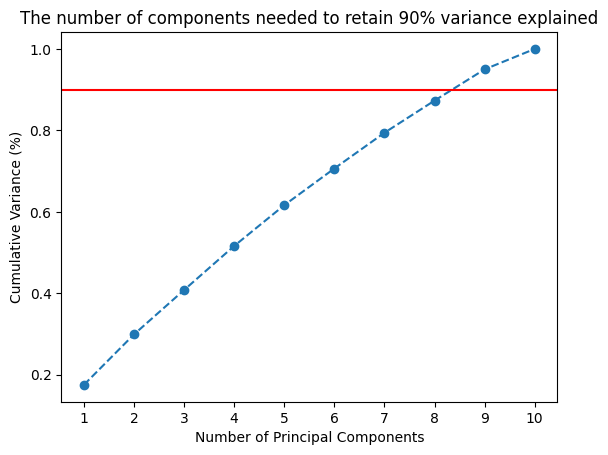

In [17]:
pca = PCA()
X_reduced = pca.fit_transform(X_scaled)
exp_var = pca.explained_variance_ratio_
cum_sum_eigvals = np.cumsum(exp_var)

plt.plot(range(1, len(cum_sum_eigvals) + 1), cum_sum_eigvals, marker="o", linestyle="--")
plt.axhline(y=0.9, color="r", linestyle="-")
plt.xticks(range(1, len(cum_sum_eigvals) + 1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance (%)")
plt.title("The number of components needed to retain 90% variance explained")

In [18]:
pca = PCA(n_components=0.9) # retain 0.9 variance explained
X_reduced = pca.fit_transform(X_scaled)

In [19]:
X_reduced.shape

(986, 9)

In [20]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=93415.24; r2=0.24
mse=30503.41; r2=0.75


In [21]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=48219.55; r2=0.61
mse=24286.13; r2=0.80


In [22]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=53484.80; r2=0.56
mse=29853.29; r2=0.76


> PCA doesn't help to improve the performance in tree-based methods

#### Decision Tree

In [23]:
# Baseline
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=15)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=33782.55; r2=0.72
[-0. -0. -0. -0. -0.]
[-41053.09090909 -35785.4213198  -25756.58883249 -34352.73096447
 -31964.91370558]


To reduce overfitting of Decision Tree
- set max depth
- pruning
- set min number of samples required at leaf nodes

In [24]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(DecisionTreeRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-21999.986 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-32313.308 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-20305.909 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-16675.187 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-47086.165 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-21739.423 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-29129.657 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-17139.780 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-18908.818 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-43598.986 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-22207.894 total time=   0.0s
[CV 2/5

[CV 1/5] END max_depth=7, min_samples_leaf=15;, score=-23345.844 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=15;, score=-32154.467 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=15;, score=-20108.166 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=15;, score=-17346.946 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=15;, score=-46755.012 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5;, score=-27490.152 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=5;, score=-39808.920 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5;, score=-21695.944 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5;, score=-28184.034 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=5;, score=-51244.901 total time=   0.0s
[CV 1/5] END max_depth=6, min_samples_leaf=9;, score=-19345.443 total time=   0.0s
[CV 2/5] END max_depth=6, min_samples_leaf=9;, score=-31413.907 total time=   0.0s

[CV 2/5] END max_depth=12, min_samples_leaf=4;, score=-30763.961 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=4;, score=-17856.287 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=4;, score=-19219.958 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=4;, score=-47704.910 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=4;, score=-28256.492 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=4;, score=-40867.324 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=4;, score=-21619.574 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=4;, score=-27256.755 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=4;, score=-52750.455 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=16;, score=-22948.394 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=16;, score=-32318.012 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=16;, score=-20349.842 total time=   0.

[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-22550.905 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-32844.483 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=18;, score=-20059.562 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=18;, score=-18496.432 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=18;, score=-46453.866 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=18;, score=-22715.892 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=18;, score=-32787.329 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=18;, score=-20064.025 total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=18;, score=-18693.614 total time=   0.0s
[CV 5/5] END max_depth=9, min_samples_leaf=18;, score=-46277.988 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=18;, score=-22718.776 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=18;, score=-32926.869 total tim

In [25]:
# Best model
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=11, min_samples_leaf=10)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=25246.39; r2=0.79
[-21742.54285866 -19377.37159293 -21556.82832759 -22509.69050797
 -15909.81888523]
[-20208.8163144  -28801.21992126 -18401.69309145 -16513.29752733
 -42306.90662737]


In [26]:
dt_reg.fit(X_scaled, y_true)

y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [27]:
joblib.dump(dt_reg, "models/decision_tree.joblib")
dt_reg = joblib.load("models/decision_tree.joblib")
y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [28]:
dot_data = tree.export_graphviz(dt_reg, out_file=None, 
                                feature_names=feature_names, filled=True, label="all", rounded=True, proportion=True)
graph = graphviz.Source(dot_data)
graph.render("res/dtree_viz", format="pdf")
graph.render("res/dtree_viz", format="svg")

'res\\dtree_viz.svg'

#### Random Forest

In [29]:
# Baseline
rf_reg = RandomForestRegressor(random_state=42)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=23925.35; r2=0.80
[-4416.43596345 -3244.25758175 -3469.10798682 -3699.48633714
 -2878.18979772]
[-19982.22613333 -25490.84069036 -19637.39799391 -14170.58111675
 -40345.70337462]


To reduce overfitting of Random Forest
- set max depth
- set min number of samples required at leaf nodes

In [30]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(RandomForestRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-26568.079 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-33696.651 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-21506.911 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-23280.859 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-44983.812 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-21190.512 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-30715.335 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-18541.430 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-16065.518 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-43649.667 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-25290.297 total time=   0.0s
[CV 2/5

[CV 3/5] END max_depth=14, min_samples_leaf=3;, score=-16487.241 total time=   0.0s
[CV 4/5] END max_depth=14, min_samples_leaf=3;, score=-14553.000 total time=   0.0s
[CV 5/5] END max_depth=14, min_samples_leaf=3;, score=-45540.434 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=16;, score=-25671.356 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=16;, score=-34179.054 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=16;, score=-20996.298 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=16;, score=-22814.355 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=16;, score=-45092.832 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=13;, score=-24475.420 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=13;, score=-32144.008 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=13;, score=-20481.140 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=13;, score=-20269.639 total t

[CV 1/5] END max_depth=13, min_samples_leaf=2;, score=-18645.574 total time=   0.0s
[CV 2/5] END max_depth=13, min_samples_leaf=2;, score=-27183.955 total time=   0.0s
[CV 3/5] END max_depth=13, min_samples_leaf=2;, score=-17054.645 total time=   0.0s
[CV 4/5] END max_depth=13, min_samples_leaf=2;, score=-14617.877 total time=   0.0s
[CV 5/5] END max_depth=13, min_samples_leaf=2;, score=-43243.965 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=12;, score=-23586.410 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=12;, score=-31804.234 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=12;, score=-19937.933 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=12;, score=-19289.684 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=12;, score=-43526.860 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-27839.211 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-34789.891 total 

[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16081.744 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43992.321 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5;, score=-23324.769 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=5;, score=-33773.322 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5;, score=-20477.961 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5;, score=-21386.311 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=5;, score=-46777.038 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=8;, score=-20773.636 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=8;, score=-30493.234 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=8;, score=-18213.363 total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=8;, score=-15916.464 total time=   0.0s
[CV 5/5] END max_depth=9, min_samples_leaf=8;, score=-44105.092 total time=   0.0s
[CV 

[CV 2/5] END max_depth=11, min_samples_leaf=3;, score=-27632.975 total time=   0.1s
[CV 3/5] END max_depth=11, min_samples_leaf=3;, score=-16176.496 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=3;, score=-14694.070 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=3;, score=-44548.513 total time=   0.1s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-28041.478 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-34956.645 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=18;, score=-21754.620 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=18;, score=-24257.788 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=18;, score=-46191.236 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=18;, score=-27229.864 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=18;, score=-34240.642 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=18;, score=-21949.747 total time=

[CV 5/5] END max_depth=7, min_samples_leaf=4;, score=-45319.003 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=8;, score=-21175.378 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=8;, score=-32002.142 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=8;, score=-18568.938 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16797.602 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43459.368 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=10;, score=-22641.685 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=10;, score=-31058.939 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=10;, score=-19103.250 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=10;, score=-17333.483 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=10;, score=-43450.129 total time=   0.0s
{'max_depth': 9, 'min_samples_leaf': 2} -23995.167170939778


In [31]:
# Best model
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=13, min_samples_leaf=2)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=24251.72; r2=0.80
[-10967.08111262  -8586.95332676  -9238.49401585  -9920.28903802
  -7471.08340804]
[-19869.69727411 -27198.12723039 -16994.85260711 -14276.81429929
 -42919.12716701]


In [32]:
rf_reg.fit(X_scaled, y_true)

y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

In [33]:
joblib.dump(rf_reg, "models/random_forest.joblib")
rf_reg = joblib.load("models/random_forest.joblib")
y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

#### Neural Network

In [34]:
def train(X_train, y_train, X_valid, y_valid, model, n_epochs=1000, lr=0.03, verbose=False):
    
    history = {"loss_train": [], "loss_valid": []}
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        # Forward pass
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        # Model evaluation
        with torch.no_grad():
            model.eval()
            y_pred_valid = model(X_valid)
            loss_valid = criterion(y_pred_valid, y_valid)
            
        if epoch % 100 == 0:
            history["loss_train"].append(loss_train.item())
            history["loss_valid"].append(loss_valid.item())
        
        if verbose and epoch % 1000 == 0:
            tqdm.write(f'Epoch [{epoch}/{n_epochs}], Training loss: {loss_train.item():.4f}, Validation loss: {loss_valid.item():.4f}')
       
    return history

In [35]:
X_pt = torch.tensor(X_scaled, dtype=torch.float32)
y_pt = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_pt, y_pt, test_size=0.2)

In [37]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train, y_train, X_valid, y_valid, mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1956751.7500, Validation loss: 2065805.1250
Epoch [1000/10000], Training loss: 64024.1680, Validation loss: 50871.8047
Epoch [2000/10000], Training loss: 66640.9453, Validation loss: 53058.5156
Epoch [3000/10000], Training loss: 69448.0938, Validation loss: 53874.7461
Epoch [4000/10000], Training loss: 61352.3906, Validation loss: 53510.1562
Epoch [5000/10000], Training loss: 53221.3555, Validation loss: 48454.8789
Epoch [6000/10000], Training loss: 58260.5078, Validation loss: 47763.5391
Epoch [7000/10000], Training loss: 45836.7852, Validation loss: 51417.6758
Epoch [8000/10000], Training loss: 51133.8008, Validation loss: 49195.7383
Epoch [9000/10000], Training loss: 46233.5703, Validation loss: 53321.6914


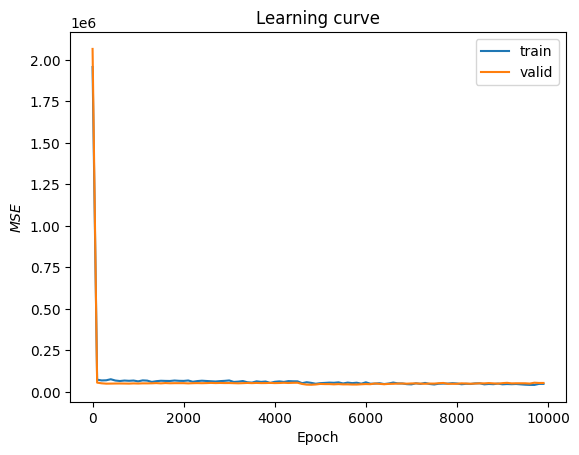

In [38]:
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_train"], label="train")
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_valid"], label="valid")
plt.legend()
plt.title("Learning curve")
plt.ylabel(r"$MSE$")
plt.xlabel("Epoch")
plt.show()

In [39]:
# K-fold cross validation
mse_train = []
mse_test = []

for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(X_pt, y_pt):
    
    # Get train and test data for k-th fold
    X_train_fold = X_pt[train_idx]
    y_train_fold = y_pt[train_idx]
    X_test_fold = X_pt[test_idx]
    y_test_fold = y_pt[test_idx]
    
    # Define model
    mlp = torch.nn.Sequential(
        torch.nn.Linear(10, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 8),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(8, 1)
    )
    
    # Train model on k-th fold training data
    history = train(X_train=X_train_fold, y_train=y_train_fold, 
          X_valid=X_test_fold, y_valid=y_test_fold, 
          model=mlp, n_epochs=10000, lr=0.03, verbose=False)
    
    mse_train.append(history["loss_train"][-1])
    mse_test.append(history["loss_valid"][-1])

In [40]:
mse_train

[57125.31640625, 63585.3125, 61979.57421875, 89451.328125, 52287.02734375]

In [41]:
mse_test

[51159.9453125, 59183.4296875, 54183.7265625, 60641.765625, 48243.09765625]

In [42]:
np.mean(mse_test)

54682.39296875

In [43]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train=X_pt, y_train=y_pt, X_valid=X_pt, y_valid=y_pt, model=mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1980458.6250, Validation loss: 1979575.0000
Epoch [1000/10000], Training loss: 78557.4375, Validation loss: 34694.0820
Epoch [2000/10000], Training loss: 74021.3594, Validation loss: 34866.5000
Epoch [3000/10000], Training loss: 70351.1875, Validation loss: 35560.6719
Epoch [4000/10000], Training loss: 77375.9609, Validation loss: 34194.9492
Epoch [5000/10000], Training loss: 65920.6875, Validation loss: 26894.0020
Epoch [6000/10000], Training loss: 64751.0117, Validation loss: 26469.6074
Epoch [7000/10000], Training loss: 55178.6680, Validation loss: 23235.1191
Epoch [8000/10000], Training loss: 60497.4414, Validation loss: 22399.3730
Epoch [9000/10000], Training loss: 56407.7422, Validation loss: 23074.4805


In [44]:
print(mlp)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)


In [45]:
torch.save(mlp, "models/mlp.pt")

In [46]:
mlp = torch.load("models/mlp.pt")
mlp.eval()

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)

In [47]:
y_pred = mlp(torch.tensor(X_scaled, dtype=torch.float32))
torch.nn.functional.mse_loss(y_pred, torch.tensor(y_true, dtype=torch.float32).view(-1, 1)).item()

22020.890625